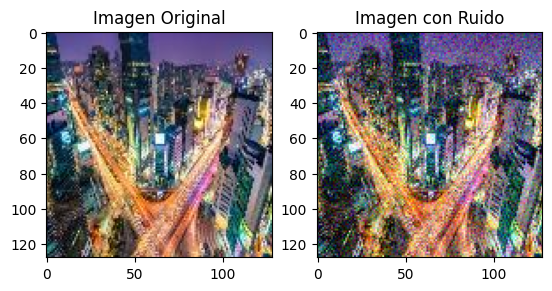

In [7]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar imágenes del conjunto de entrenamiento
city_train_path = "processed_dataset/city/train-city"
forest_train_path = "processed_dataset/forest/train-forest"
img_size = (128, 128)

def load_images(folder):
    images = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

city_train = load_images(city_train_path)
forest_train = load_images(forest_train_path)


# Añadir Ruido Gaussiano
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image


# Añadir Ruido a las Imágene
X_train = np.concatenate([city_train, forest_train])
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])


# Ejemplo de Imagen Ruidosa
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train[0])
axes[0].set_title("Imagen Original")
axes[1].imshow(X_train_noisy[0])
axes[1].set_title("Imagen con Ruido")
plt.show()


In [20]:
from tensorflow.keras.models import Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow.keras.layers as layers

# Inicializar un run de W&B
wandb.init(project="autoencoder-denoising", config={
    "epochs": 50,
    "batch_size": 16,
    "img_size": img_size,
    "architecture": "autoencoder",
    "dataset": "city and forest"
})

# Configuración
config = wandb.config

# Crear el Autoencoder
input_img = layers.Input(shape=(*img_size, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Resumen del Modelo
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath='models/model-best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
history = autoencoder.fit(
    X_train_noisy,
    X_train,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    validation_split=0.1,
    callbacks=callbacks
)
wandb.finish()

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3704 - loss: 0.0911
Epoch 1: val_loss improved from inf to 0.07244, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3732 - loss: 0.0909 - val_accuracy: 0.6676 - val_loss: 0.0724
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4390 - loss: 0.0771
Epoch 2: val_loss improved from 0.07244 to 0.04769, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4400 - loss: 0.0764 - val_accuracy: 0.6684 - val_loss: 0.0477
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4270 - loss: 0.0507
Epoch 3: val_loss improved from 0.04769 to 0.03210, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4285 - loss: 0.0501 - val_accuracy: 0.6060 - val_loss: 0.0321
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4210 - loss: 0.0377
Epoch 4: val_loss improved from 0.03210 to 0.02729, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4216 - loss: 0.0376 - val_accuracy: 0.5594 - val_loss: 0.0273
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5454 - loss: 0.0307
Epoch 5: val_loss improved from 0.02729 to 0.02662, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5472 - loss: 0.0307 - val_accuracy: 0.5009 - val_loss: 0.0266
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5793 - loss: 0.0290
Epoch 6: val_loss improved from 0.02662 to 0.02379, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5811 - loss: 0.0289 - val_accuracy: 0.5820 - val_loss: 0.0238
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6218 - loss: 0.0249
Epoch 7: val_loss improved from 0.02379 to 0.02303, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6208 - loss: 0.0249 - val_accuracy: 0.6129 - val_loss: 0.0230
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6173 - loss: 0.0264
Epoch 8: val_loss did not improve from 0.02303
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6171 - loss: 0.0263 - val_accuracy: 0.4486 - val_loss: 0.0240
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6349 - loss: 0.0244
Epoch 9: val_loss improved from 0.02303 to 0.02249, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6320 - loss: 0.0244 - val_accuracy: 0.6251 - val_loss: 0.0225
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6364 - loss: 0.0231
Epoch 10: val_loss improved from 0.02249 to 0.02016, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6363 - loss: 0.0231 - val_accuracy: 0.6739 - val_loss: 0.0202
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6385 - loss: 0.0220
Epoch 11: val_loss improved from 0.02016 to 0.01970, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6397 - loss: 0.0219 - val_accuracy: 0.6779 - val_loss: 0.0197
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6679 - loss: 0.0205
Epoch 12: val_loss did not improve from 0.01970
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6671 - loss: 0.0205 - val_accuracy: 0.6441 - val_loss: 0.0198
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7077 - loss: 0.0203
Epoch 13: val_loss improved from 0.01970 to 0.01852, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7060 - loss: 0.0203 - val_accuracy: 0.7551 - val_loss: 0.0185
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7231 - loss: 0.0200
Epoch 14: val_loss improved from 0.01852 to 0.01820, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7229 - loss: 0.0200 - val_accuracy: 0.7682 - val_loss: 0.0182
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7690 - loss: 0.0190
Epoch 15: val_loss improved from 0.01820 to 0.01772, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7679 - loss: 0.0190 - val_accuracy: 0.8085 - val_loss: 0.0177
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7806 - loss: 0.0189
Epoch 16: val_loss did not improve from 0.01772
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7805 - loss: 0.0190 - val_accuracy: 0.8319 - val_loss: 0.0179
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7886 - loss: 0.0197
Epoch 17: val_loss improved from 0.01772 to 0.01730, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7891 - loss: 0.0196 - val_accuracy: 0.8438 - val_loss: 0.0173
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8166 - loss: 0.0183
Epoch 18: val_loss did not improve from 0.01730
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8153 - loss: 0.0184 - val_accuracy: 0.8514 - val_loss: 0.0177
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8204 - loss: 0.0182
Epoch 19: val_loss improved from 0.01730 to 0.01711, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8195 - loss: 0.0182 - val_accuracy: 0.8523 - val_loss: 0.0171
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8164 - loss: 0.0180
Epoch 20: val_loss did not improve from 0.01711
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8157 - loss: 0.0180 - val_accuracy: 0.8645 - val_loss: 0.0172
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8087 - loss: 0.0188
Epoch 21: val_loss improved from 0.01711 to 0.01679, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8095 - loss: 0.0187 - val_accuracy: 0.8636 - val_loss: 0.0168
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8160 - loss: 0.0182
Epoch 22: val_loss did not improve from 0.01679
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8167 - loss: 0.0182 - val_accuracy: 0.8587 - val_loss: 0.0169
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8313 - loss: 0.0178
Epoch 23: val_loss improved from 0.01679 to 0.01661, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8308 - loss: 0.0178 - val_accuracy: 0.8641 - val_loss: 0.0166
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8368 - loss: 0.0185
Epoch 24: val_loss improved from 0.01661 to 0.01647, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8359 - loss: 0.0185 - val_accuracy: 0.8675 - val_loss: 0.0165
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8298 - loss: 0.0176
Epoch 25: val_loss improved from 0.01647 to 0.01643, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8298 - loss: 0.0176 - val_accuracy: 0.8637 - val_loss: 0.0164
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8311 - loss: 0.0168
Epoch 26: val_loss did not improve from 0.01643
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8308 - loss: 0.0169 - val_accuracy: 0.8587 - val_loss: 0.0170
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8293 - loss: 0.0175
Epoch 27: val_loss improved from 0.01643 to 0.01621, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8290 - loss: 0.0175 - val_accuracy: 0.8604 - val_loss: 0.0162
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8122 - loss: 0.0186
Epoch 28: val_loss did not improve from 0.01621
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8134 - loss: 0.0185 - val_accuracy: 0.8417 - val_loss: 0.0163
Epoch 29/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8315 - loss: 0.0171
Epoch 29: val_loss improved from 0.01621 to 0.01607, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8307 - loss: 0.0172 - val_accuracy: 0.8634 - val_loss: 0.0161
Epoch 30/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8280 - loss: 0.0176
Epoch 30: val_loss improved from 0.01607 to 0.01595, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8278 - loss: 0.0176 - val_accuracy: 0.8635 - val_loss: 0.0159
Epoch 31/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8339 - loss: 0.0169
Epoch 31: val_loss did not improve from 0.01595
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8337 - loss: 0.0170 - val_accuracy: 0.8686 - val_loss: 0.0163
Epoch 32/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8245 - loss: 0.0179
Epoch 32: val_loss did not improve from 0.01595
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8247 - loss: 0.0179 - val_accuracy: 0.8604 - val_loss: 0.0160
Epoch 33/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8378 - loss: 0.0178
Epoch 33: val_loss did not improve from 0.01595
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8374 - loss: 0.0177 - val_accuracy: 0.8678 - val_loss: 0.0160
Epoch 34/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8304 - loss: 0.0171
Epoch 34: val_loss improved from 0.01595 to 0.01570, saving mode

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8306 - loss: 0.0171 - val_accuracy: 0.8637 - val_loss: 0.0157
Epoch 35/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8453 - loss: 0.0170
Epoch 35: val_loss improved from 0.01570 to 0.01563, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8442 - loss: 0.0170 - val_accuracy: 0.8694 - val_loss: 0.0156
Epoch 36/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8235 - loss: 0.0166
Epoch 36: val_loss improved from 0.01563 to 0.01555, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8242 - loss: 0.0166 - val_accuracy: 0.8710 - val_loss: 0.0156
Epoch 37/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8225 - loss: 0.0167
Epoch 37: val_loss improved from 0.01555 to 0.01551, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8237 - loss: 0.0167 - val_accuracy: 0.8710 - val_loss: 0.0155
Epoch 38/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8447 - loss: 0.0168
Epoch 38: val_loss did not improve from 0.01551
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8439 - loss: 0.0168 - val_accuracy: 0.8672 - val_loss: 0.0158
Epoch 39/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8232 - loss: 0.0169
Epoch 39: val_loss improved from 0.01551 to 0.01549, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8244 - loss: 0.0169 - val_accuracy: 0.8704 - val_loss: 0.0155
Epoch 40/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8416 - loss: 0.0167
Epoch 40: val_loss improved from 0.01549 to 0.01544, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8410 - loss: 0.0167 - val_accuracy: 0.8724 - val_loss: 0.0154
Epoch 41/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8431 - loss: 0.0165
Epoch 41: val_loss improved from 0.01544 to 0.01531, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8424 - loss: 0.0164 - val_accuracy: 0.8736 - val_loss: 0.0153
Epoch 42/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8363 - loss: 0.0168
Epoch 42: val_loss did not improve from 0.01531
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8364 - loss: 0.0167 - val_accuracy: 0.8709 - val_loss: 0.0154
Epoch 43/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8391 - loss: 0.0157
Epoch 43: val_loss improved from 0.01531 to 0.01522, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8388 - loss: 0.0157 - val_accuracy: 0.8748 - val_loss: 0.0152
Epoch 44/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8305 - loss: 0.0164
Epoch 44: val_loss did not improve from 0.01522
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8311 - loss: 0.0164 - val_accuracy: 0.8724 - val_loss: 0.0154
Epoch 45/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8303 - loss: 0.0165
Epoch 45: val_loss did not improve from 0.01522
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8307 - loss: 0.0165 - val_accuracy: 0.8769 - val_loss: 0.0152
Epoch 46/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8432 - loss: 0.0161
Epoch 46: val_loss improved from 0.01522 to 0.01513, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8426 - loss: 0.0161 - val_accuracy: 0.8730 - val_loss: 0.0151
Epoch 47/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8296 - loss: 0.0171
Epoch 47: val_loss improved from 0.01513 to 0.01506, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8302 - loss: 0.0170 - val_accuracy: 0.8738 - val_loss: 0.0151
Epoch 48/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8352 - loss: 0.0162
Epoch 48: val_loss improved from 0.01506 to 0.01500, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8353 - loss: 0.0161 - val_accuracy: 0.8753 - val_loss: 0.0150
Epoch 49/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8287 - loss: 0.0168
Epoch 49: val_loss improved from 0.01500 to 0.01494, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8293 - loss: 0.0167 - val_accuracy: 0.8770 - val_loss: 0.0149
Epoch 50/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8336 - loss: 0.0155
Epoch 50: val_loss improved from 0.01494 to 0.01492, saving model to model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8339 - loss: 0.0155 - val_accuracy: 0.8777 - val_loss: 0.0149


epoch/accuracy,▁▂▂▁▄▄▄▄▅▅▆▇▇▇▇█████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▄▄▃▂▁▃▃▄▄▄▆▇▇▇███████▇██████████████████
epoch/val_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁
val_loss,▁
epoch/accuracy,0.83717
epoch/epoch,49
epoch/learning_rate,0.001


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


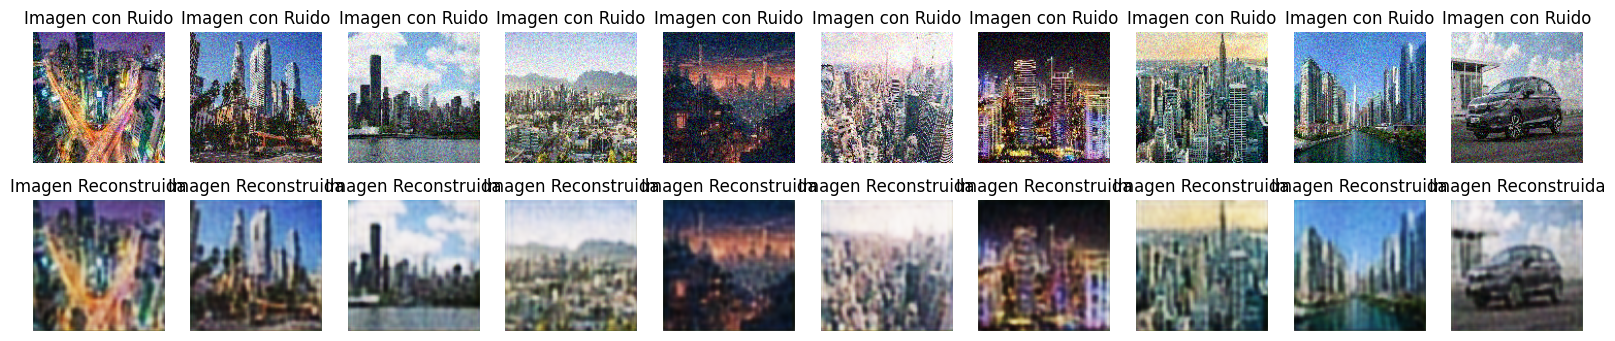

Train MSE: 0.015756931985111695
Train PSNR: 18.025283396158272 dB


/tmp/ipykernel_3259/1110211094.py:29: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_train, decoded_imgs)


In [31]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_train_noisy)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

# Mean Squared Error
mse = np.mean((X_train - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_train, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


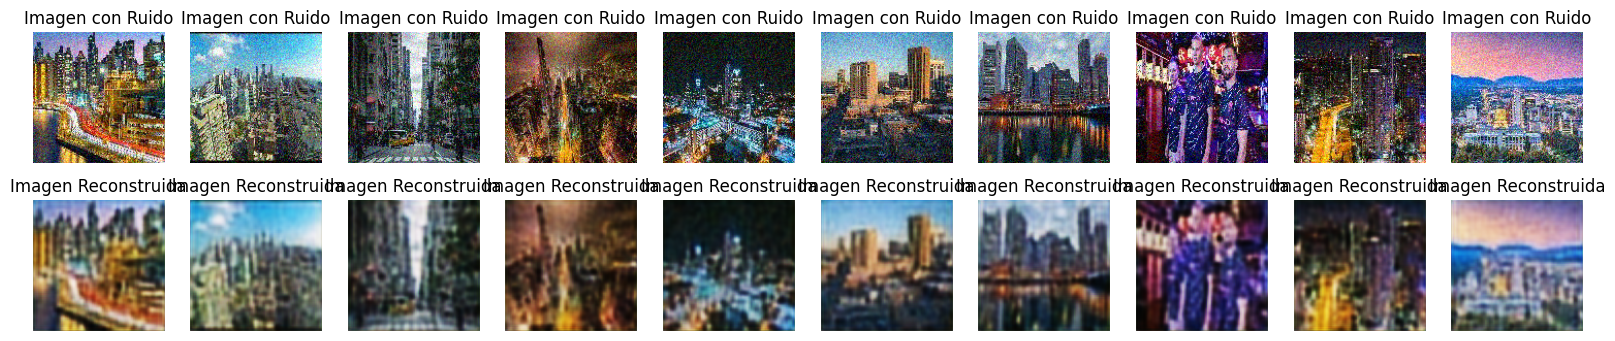

Train MSE: 0.01596727778785699
Train PSNR: 17.967691190828653 dB


/tmp/ipykernel_3259/2453847611.py:37: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_test, decoded_imgs)


In [33]:
# Prueba con Imágenes Nuevas
city_test_path = "processed_dataset/city/test-city"
forest_test_path = "processed_dataset/forest/test-forest"

city_test = load_images(city_test_path)
forest_test = load_images(forest_test_path)

X_test = np.concatenate([city_test, forest_test])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test])

decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')
    
plt.show()


# Mean Squared Error
mse = np.mean((X_test - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_test, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")